## 使用Parallel计算（占用8核心）

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
import os

# Set the working directory
new_dir = '/Users/zhy/Desktop/广发基金/Python'
os.chdir(new_dir)

# Read the data from Excel files
bi_dur = pd.read_excel('bi_dur.xlsx')
bi_rts = pd.read_excel('bi_rts.xlsx')
fund_rts = pd.read_excel('fund_rts.xlsx')

# Prepare data
bi_rts = bi_rts.iloc[:, 1:].apply(pd.to_numeric).to_numpy()
bi_dur = bi_dur.iloc[:, 1:].apply(pd.to_numeric).to_numpy()
fund_rts = fund_rts.iloc[:, 1:].apply(pd.to_numeric)

window_size = 50
rolled_window = 3
bi_rts_rolled = np.array([bi_rts[i:i+rolled_window].mean(axis=0) for i in range(len(bi_rts) - rolled_window + 1)])
bi_dur_rolled = np.array([bi_dur[i:i+rolled_window].mean(axis=0) for i in range(len(bi_dur) - rolled_window + 1)])
fund_rts_rolled = np.array([fund_rts.iloc[i:i+rolled_window].mean(axis=0) for i in range(len(fund_rts) - rolled_window + 1)])

def process_column(item_counter, item, fund_rts_rolled, bi_rts_rolled, bi_dur_rolled):
    fund = fund_rts_rolled[:, item_counter]
    weighted_duration = np.zeros(len(bi_rts_rolled))
    best_coefs_store = []
    best_indices_store = []

    print(f"Processing column {item_counter}/{fund_rts_rolled.shape[1]}: {item}")

    for i in range(len(bi_rts_rolled)):
        if fund[i] == 0 or fund[i] > bi_rts_rolled[i, :].max():
            continue

        daily_bi_rts = bi_rts_rolled[i]
        daily_bi_dur = bi_dur_rolled[i]

        clusters = KMeans(n_clusters=4, n_init='auto', random_state=2024).fit(daily_bi_rts.reshape(-1, 1)).labels_

        n_clusters = np.max(clusters) + 1
        best_indices = []

        for cluster in range(n_clusters):
            indices_in_cluster = np.where(clusters == cluster)[0]
            X = bi_rts_rolled[:, indices_in_cluster]
            r_squared_scores = np.array([LinearRegression().fit(X[:, j].reshape(-1, 1), fund).score(X[:, j].reshape(-1, 1), fund) for j in range(X.shape[1])])
            best_index = indices_in_cluster[np.argmax(r_squared_scores)]
            best_indices.append(best_index)

        X_best = bi_rts_rolled[:, best_indices]
        n_windows = len(fund) - window_size + 1
        coefs = np.zeros((n_windows, X_best.shape[1]))

        for j in range(n_windows):
            y_window = fund[j:j + window_size]
            X_window = X_best[j:j + window_size]
            weights = 1 / (y_window.var() if y_window.var() != 0 else 1)

            def objective(coef):
                residuals = y_window - X_window @ coef
                return np.sum(weights * residuals ** 2)

            initial_coef = LinearRegression().fit(X_window, y_window).coef_
            cons = [{'type': 'ineq', 'fun': lambda coef: coef},
                    {'type': 'ineq', 'fun': lambda coef: 1.4 - coef},
                    {'type': 'ineq', 'fun': lambda coef: np.sum(coef) - 0.8},
                    {'type': 'ineq', 'fun': lambda coef: 1.4 - np.sum(coef)}]

            result = minimize(objective, initial_coef, constraints=cons, method='SLSQP')
            coefs[j] = result.x

        best_coef = coefs.mean(axis=0)
        best_coefs_store.append(best_coef)
        best_indices_store.append(best_indices)
        weighted_duration[i] = np.sum(best_coef * daily_bi_dur[best_indices])

    return (item, weighted_duration, best_coefs_store, best_indices_store)

results = Parallel(n_jobs=-1)(delayed(process_column)(item_counter, item, fund_rts_rolled, bi_rts_rolled, bi_dur_rolled)
                              for item_counter, item in enumerate(fund_rts.columns, start=0))

weighted_durations = pd.DataFrame({item: duration for item, duration, _, _ in results}, index=fund_rts_rolled.index)
all_best_coefs = {item: coefs for item, _, coefs, _ in results}
all_best_indices = {item: indices for item, _, _, indices in results}

# Final result
# print(weighted_durations)
# print(all_best_coefs)
# print(all_best_indices)

## 直接计算（占用2核心）

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import WLS
import os

# Set the working directory
new_dir = '/Users/zhy/Desktop/广发基金/Python'
os.chdir(new_dir)

# Read the data from Excel files
bi_dur = pd.read_excel('bi_dur.xlsx')
bi_rts = pd.read_excel('bi_rts.xlsx')
fund_rts = pd.read_excel('fund_rts.xlsx')
duration = pd.read_excel('duration.xlsx')

# Set seed for reproducibility
np.random.seed(2024)

# Prepare data
bi_rts = bi_rts.iloc[:, 1:].apply(pd.to_numeric)
bi_dur = bi_dur.iloc[:, 1:].apply(pd.to_numeric)
fund_rts = fund_rts.iloc[:, 1:].apply(pd.to_numeric)

window_size = 50
rolled_window = 3
bi_rts_rolled = bi_rts.rolling(window=rolled_window).mean().dropna().to_numpy()
# bi_dur_rolled = bi_dur.rolling(window=rolled_window).mean().dropna().to_numpy()
fund_rts_rolled = fund_rts.rolling(window=rolled_window).mean().dropna()

results = []
all_best_coefs = {}
all_best_indices = {}

for item_counter, item in enumerate(fund_rts_rolled.columns, start=1):
    fund = fund_rts_rolled[item].values
    weighted_duration = np.zeros(len(bi_rts_rolled))
    best_coefs_store = []  # Store best_coef for each iteration
    best_indices_store = []  # Store best_indices for each iteration

    print(f"Processing column {item_counter}/{len(fund_rts_rolled.columns)}: {item}")

    for i in range(len(bi_rts_rolled)):
        if fund[i] == 0 or fund[i] > bi_rts_rolled[i, :].max():
            continue  # Skip the day where fund returns are zero or exceed the threshold

        daily_bi_rts = bi_rts_rolled[i]
        daily_bi_dur = np.array(bi_dur)[i]

        clusters = KMeans(n_clusters=4, n_init='auto', random_state=2024).fit(
            daily_bi_rts.reshape(-1, 1)
        ).labels_

        n_clusters = np.max(clusters) + 1
        best_indices = []

        for cluster in range(n_clusters):
            indices_in_cluster = np.where(clusters == cluster)[0]
            best_r_squared = -np.inf
            best_index = -1

            for idx in indices_in_cluster:
                X = bi_rts_rolled[:, idx].reshape(-1, 1)
                model = LinearRegression().fit(X, fund)
                r_squared = model.score(X, fund)

                if r_squared > best_r_squared:
                    best_r_squared = r_squared
                    best_index = idx

            best_indices.append(best_index)

        X_best = bi_rts_rolled[:, best_indices]
        n_windows = len(fund) - window_size + 1
        coefs = np.zeros((n_windows, X_best.shape[1]))

        for j in range(n_windows):
            y_window = fund[j:j + window_size]
            X_window = X_best[j:j + window_size]
            weights = 1 / (y_window.var() if y_window.var() != 0 else 1)  # Adjust weights as needed

            def objective(coef):
                residuals = y_window - X_window @ coef
                return np.sum(weights * residuals ** 2)

            initial_coef = LinearRegression().fit(X_window, y_window).coef_
            cons = [
                {'type': 'ineq', 'fun': lambda coef: coef - 0},  # coef >= 0
                {'type': 'ineq', 'fun': lambda coef: 1.4 - coef},  # coef <= 1.4
                {'type': 'ineq', 'fun': lambda coef: np.sum(coef) - 0.8},  # sum(coef) >= 0.8
                {'type': 'ineq', 'fun': lambda coef: 1.4 - np.sum(coef)}  # sum(coef) <= 1.4
            ]

            result = minimize(objective, initial_coef, constraints=cons, method='SLSQP')
            coefs[j] = result.x

        best_coef = coefs.mean(axis=0)
        best_coefs_store.append(best_coef)  # Store the best_coef for this iteration
        best_indices_store.append(best_indices)  # Store the best_indices for this iteration
        weighted_duration[i] = np.sum(best_coef * daily_bi_dur[best_indices])

    results.append((item, weighted_duration))
    all_best_coefs[item] = best_coefs_store  # Store the best_coef for each item
    all_best_indices[item] = best_indices_store  # Store the best_indices for each item

weighted_durations = pd.DataFrame({item: duration for item, duration in results}, index=fund_rts_rolled.index)

# Final result
# print(weighted_durations)
# print(all_best_coefs)
# print(all_best_indices)

Processing column 1/15: 000037.OF
Processing column 2/15: 003039.OF
Processing column 3/15: 003040.OF
Processing column 4/15: 003223.OF
Processing column 5/15: 003819.OF
Processing column 6/15: 004020.OF
Processing column 7/15: 004027.OF
Processing column 8/15: 004028.OF
Processing column 9/15: 006670.OF
Processing column 10/15: 006869.OF
Processing column 11/15: 006970.OF
Processing column 12/15: 007396.OF
Processing column 13/15: 007598.OF
Processing column 14/15: 007778.OF
Processing column 15/15: 013449.OF


# 可视化

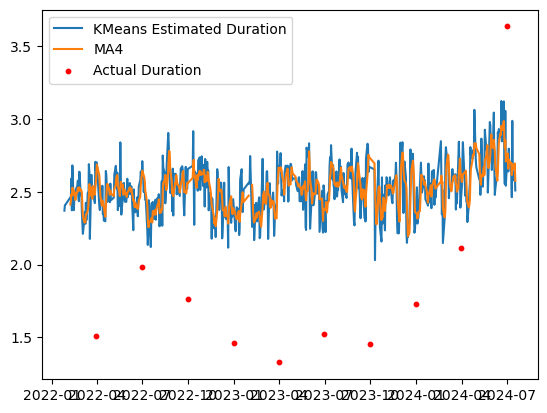

In [25]:
import matplotlib.pyplot as plt
result = weighted_durations
bi_rts = pd.read_excel('bi_rts.xlsx')
duration = pd.read_excel('duration.xlsx')
km_result = pd.concat([bi_rts.iloc[3:, [0]].reset_index(drop=True), result.reset_index(drop=True)], axis=1)

df = km_result

df = df[df != 0]
df['median'] = df.iloc[:, 1:].median(axis=1)
df['ma4'] = df['median'].rolling(4).mean()
duration['median'] = duration.iloc[:, 1:].median(axis=1)

plt.plot(df.date, df['median'], label='KMeans Estimated Duration')
plt.plot(df.date, df['ma4'], label='MA4')
plt.scatter(duration.date, duration['median'], color='red', s=10, label='Actual Duration')
plt.legend()
plt.show()

# def print_clusters(data, clusters):
#     plt.scatter(data[:, 0], data[:, 1], c=clusters)
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.title('Clusters')
#     plt.show()

# print_clusters(np.vstack([daily_bi_rts, daily_bi_dur]).T, clusters)



<Figure size 1000x600 with 0 Axes>

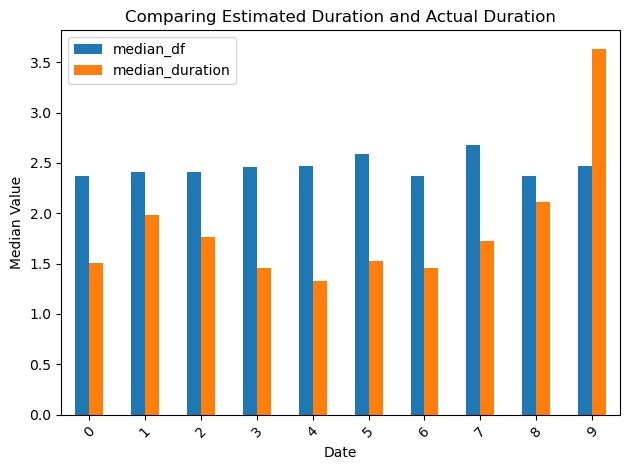

In [26]:
# Align the two dataframes on the index (date)
merged_df = df[['median']].join(duration[['median']], lsuffix='_df', rsuffix='_duration')

# Drop rows where there are NaN values (no matching date)
merged_df.dropna(inplace=True)

# Plotting the values side by side
plt.figure(figsize=(10, 6))

# Create the bar plot
merged_df.plot(kind='bar')

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Median Value')
plt.title('Comparing Estimated Duration and Actual Duration')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

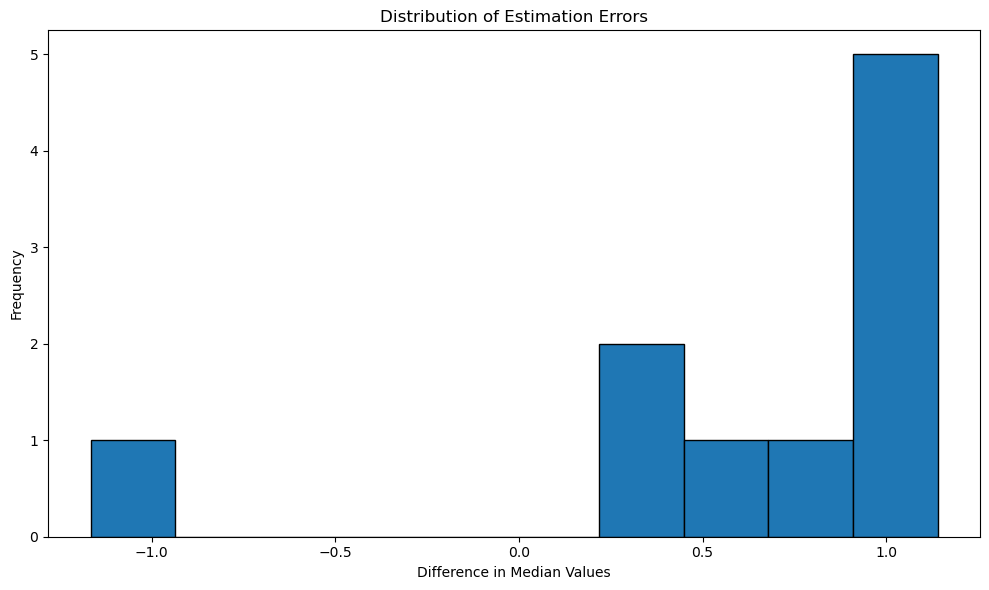

In [27]:
merged_df['difference'] = merged_df['median_df'] - merged_df['median_duration']
# Plotting the differences as a histogram
plt.figure(figsize=(10, 6))

# Create the histogram
plt.hist(merged_df['difference'], bins=10, edgecolor='black')

# Set the labels and title
plt.xlabel('Difference in Median Values')
plt.ylabel('Frequency')
plt.title('Distribution of Estimation Errors')

# Show the plot
plt.tight_layout()
plt.show()

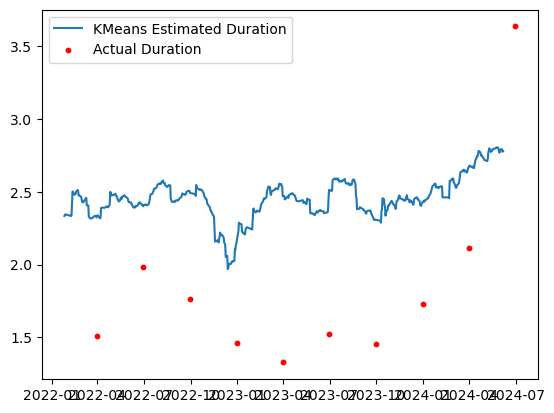

In [32]:
df = weighted_durations.rolling(window=30).mean().dropna()
df = pd.concat([bi_rts.iloc[3:, [0]].reset_index(drop=True), df.reset_index(drop=True)], axis=1)

df['median'] = df.iloc[:, 1:].median(axis=1)
df['ma4'] = df['median'].rolling(4).mean()
duration['median'] = duration.iloc[:, 1:].median(axis=1)

plt.plot(df.date, df['median'], label='KMeans Estimated Duration')
plt.scatter(duration.date, duration['median'], color='red', s=10, label='Actual Duration')
plt.legend()
plt.show()

In [29]:
import csv
df.to_csv('result.csv')